In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy

In [23]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [24]:
# data = pd.read_csv("D:/Arshdeep/McMaster/CPS/DL Project/age_gender.csv")
data = pd.read_csv("/content/sample_data/age_gender.csv")

print(data.shape)
data.head()

(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [25]:
data = data.drop("img_name", axis=1)

In [26]:
columns = ["age","gender","ethnicity"]
y = data.drop("pixels", axis = 1)
x = data.drop(columns, axis = 1)

In [27]:
x.head()

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [28]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


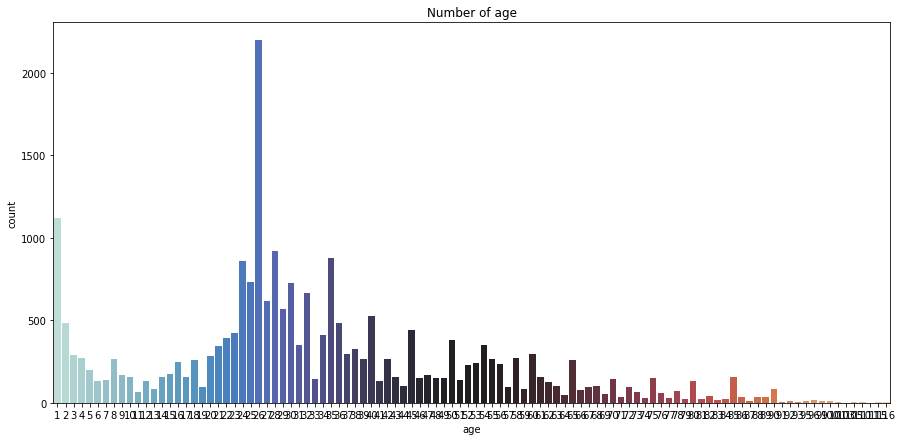

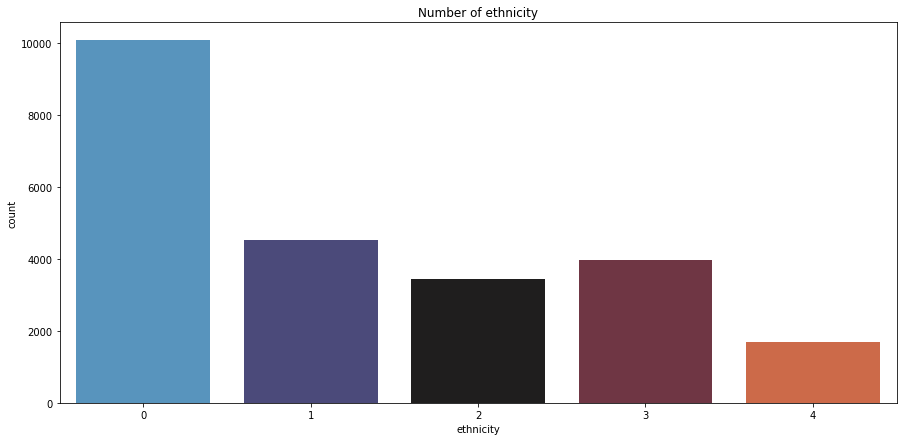

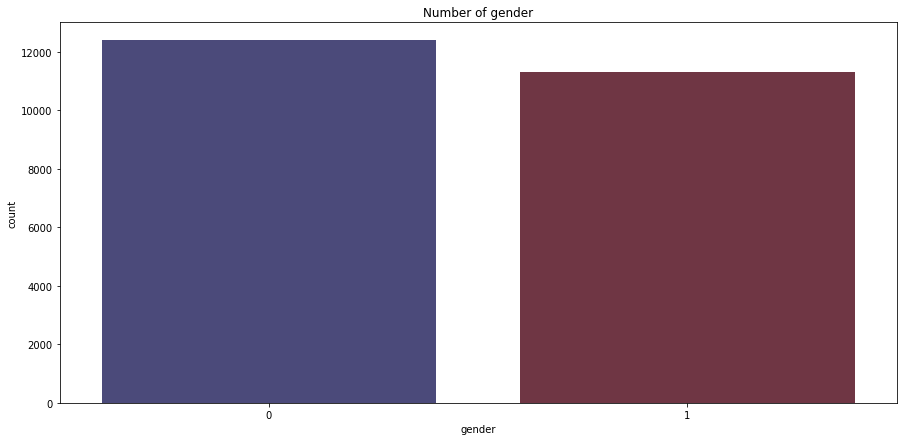

In [29]:
for i in y.columns :
    plt.figure(figsize=(15,7))
    g = sns.countplot(y[i], palette="icefire")
    plt.title("Number of {}".format(i))

In [30]:
# Image shape

num_pixels = len(x['pixels'][0].split(" "))
img_height = int(np.sqrt(len(x['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(x['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [31]:
# Reshaping the data

x = pd.Series(x["pixels"])
x = x.apply(lambda x: x.split(' '))
x = x.apply(lambda x: np.array(list(map(lambda z: np.int(z), x))))
x = np.array(x)
x = np.stack(np.array(x), axis=0)
x = np.reshape(x, (-1, 48, 48))

# reshape data
x = x.reshape(-1,48,48,1)
print("x shape: ",x.shape)

x shape:  (23705, 48, 48, 1)


In [32]:
y["age"] = pd.cut(y["age"],bins=[0,3,18,45,64,116],labels=["0","1","2","3","4"])

age_matrix = np.array(y["age"]) 
gender_matrix = np.array(y["gender"])
ethnicity_matrix = np.array(y["ethnicity"])
age = to_categorical(age_matrix, num_classes = 5)
gender = to_categorical(y["gender"], num_classes = 2)
ethnicity = to_categorical(ethnicity_matrix, num_classes = 5)
print(age, gender, ethnicity)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]] [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [33]:
# Normalize the data
x = x / 255.0
x = x / 255.0

In [34]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x)

## Age Classification ##

In [35]:
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(x, age, test_size= 0.20)
X_train_age,X_val_age, y_train_age,y_val_age = train_test_split(X_train_age,y_train_age,random_state = 21, test_size = 0.15)

In [36]:
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D

In [37]:
def model_upd(num_classes, activation, loss):
  ## MobileNet
  base_model = tf.keras.applications.MobileNet(weights = None, include_top = False, input_shape= (48,48,1))
  new_x = base_model.output
  new_x = GlobalAveragePooling2D()(new_x)
  new_x = Dense(16, activation = 'relu')(new_x)

  new_x = Dense(num_classes, activation = activation)(new_x)
  model = Model(inputs = base_model.input, outputs = new_x)
  for layer in base_model.layers:
    layer.trainable = True

  model.compile(optimizer='Adam',
                loss= loss,
                metrics=['accuracy'])

  return model



In [38]:
def model_vgg(num_classes, activation, loss):
  ## VGG16
  base_model = tf.keras.applications.vgg16.VGG16(weights = None, include_top = False, input_shape= (48,48,1))
  new_x = base_model.output
  new_x = GlobalAveragePooling2D()(new_x)
  new_x = Dense(16, activation = 'relu')(new_x)

  new_x = Dense(num_classes, activation = activation)(new_x)
  model = Model(inputs = base_model.input, outputs = new_x)
  for layer in base_model.layers:
    layer.trainable = True

  model.compile(optimizer='Adam',
                loss= loss,
                metrics=['accuracy'])

  return model

In [39]:
def model(num_classes, activation, loss):

    model = Sequential() 
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"))
    # model.add(BatchNormalization())
    # model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation= activation))
    model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    


    return model

In [44]:
model_age = model(5,"softmax",'categorical_crossentropy')

model_age.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                      

In [41]:
early_stopping = EarlyStopping(patience=3, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

## Age: CNN ##

In [ ]:
batch_size = 32

model_age = model(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size, epochs = 7, validation_data = (X_val_age,y_val_age), steps_per_epoch= X_train_age.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/7
503/503 [==============================] - 87s 171ms/step - loss: 0.9425 - accuracy: 0.6502 - val_loss: 1.5016 - val_accuracy: 0.1782 - lr: 0.0010
Epoch 2/7
364/503 [====================>.........] - ETA: 21s - loss: 0.7663 - accuracy: 0.7045

In [ ]:
model_age2 = model(5,"softmax",'categorical_crossentropy')
history_age = model_age2.fit(X_train_age, y_train_age, batch_size=batch_size, epochs = 8, validation_data = (X_val_age,y_val_age), steps_per_epoch= X_train_age.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
import plotly.express as px
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

## Age: VGG16 ##

In [ ]:
model_age = model_vgg(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size, epochs = 10, validation_data = (X_val_age,y_val_age), steps_per_epoch= X_train_age.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
import plotly.express as px
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

## Age: MobileNet ##

In [ ]:
epochs = 7
model_age = model_upd(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size, epochs = epochs, validation_data = (X_val_age,y_val_age), steps_per_epoch= X_train_age.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
import plotly.express as px
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

## Gender Classification ##

In [ ]:
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(x, gender, test_size= 0.15)
X_train_gender,X_val_gender, y_train_gender,y_val_gender = train_test_split(X_train_gender,y_train_gender,random_state = 21, test_size = 0.15)

## Gender: CNN ##

In [ ]:
epochs = 5
model_gender = model(2,"softmax",'categorical_crossentropy')
history_gender = model_gender.fit(X_train_gender, y_train_gender, batch_size=batch_size, epochs = epochs, validation_data = (X_val_gender,y_val_gender), steps_per_epoch= X_train_gender.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
import plotly.express as px
fig = px.line(
    history_gender.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

## Gender: MobileNet ##

In [ ]:
epochs = 8
model_gender = model_upd(2,"softmax",'categorical_crossentropy')
history_gender = model_gender.fit(X_train_gender, y_train_gender, batch_size=batch_size, epochs = epochs, validation_data = (X_val_gender,y_val_gender), steps_per_epoch= X_train_gender.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
import plotly.express as px
fig = px.line(
    history_gender.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

## Gender: VGG16 ##

In [ ]:
model_gender = model_vgg(2,"softmax",'categorical_crossentropy')
history_gender = model_gender.fit(X_train_gender, y_train_gender, batch_size=batch_size, epochs = 9, validation_data = (X_val_gender,y_val_gender), steps_per_epoch= X_train_gender.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
import plotly.express as px
fig = px.line(
    history_gender.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
model2_gender = model_vgg(2,"softmax",'categorical_crossentropy')
history_gender = model2_gender.fit(X_train_gender, y_train_gender, batch_size=batch_size, epochs = 3, validation_data = (X_val_gender,y_val_gender), steps_per_epoch= X_train_gender.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
loss, acc = model2_gender.evaluate(X_test_gender, y_test_gender, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

## Age: RESNET50 ##

In [ ]:
from keras.applications.resnet import ResNet50
def model_resnet(num_classes, activation, loss):
  ## ResNet50
  base_model = tf.keras.applications.resnet50.ResNet50(weights = None, include_top = False, input_shape= (48,48,1))
  new_x = base_model.output
  new_x = GlobalAveragePooling2D()(new_x)
  new_x = Dense(16, activation = 'relu')(new_x)

  new_x = Dense(num_classes, activation = activation)(new_x)
  model = Model(inputs = base_model.input, outputs = new_x)
  for layer in base_model.layers:
    layer.trainable = True

  model.compile(optimizer='Adam',
                loss= loss,
                metrics=['accuracy'])

  return model

In [ ]:
model_age = model_resnet(5,"softmax",'categorical_crossentropy')
history_age = model_age.fit(X_train_age, y_train_age, batch_size=batch_size, epochs = 10, validation_data = (X_val_age,y_val_age), steps_per_epoch= X_train_age.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
import plotly.express as px
fig = px.line(
    history_age.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
loss, acc = model_age.evaluate(X_test_age, y_test_age, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

## Gender: RESNET50 ##

In [ ]:
model_gender = model_resnet(2,"softmax",'categorical_crossentropy')
history_gender = model_gender.fit(X_train_gender, y_train_gender, batch_size=batch_size, epochs = 9, validation_data = (X_val_gender,y_val_gender), steps_per_epoch= X_train_gender.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

In [ ]:
import plotly.express as px
fig = px.line(
    history_gender.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()

In [ ]:
loss, acc = model_gender.evaluate(X_test_gender, y_test_gender, verbose=1)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))